In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Load Data
try:
    # 1A. Load Matches (Standard UTF-8 is usually fine here)
    df_matches = pd.read_csv('data/epl_matches.csv')
    
    # 1B. Load Stadiums (Add encoding='latin-1' to fix UnicodeDecodeError)
    try:
        df_stadiums = pd.read_csv('data/stadiums.csv', encoding='latin-1')
    except:
        # If latin-1 fails, try cp1252
        df_stadiums = pd.read_csv('data/stadiums.csv', encoding='cp1252')

    # 2. Smart Fix for the Date Column
    found_date = False
    possible_names = ['date', 'Match Date', 'MatchDate', 'DATE']
    
    for name in possible_names:
        if name in df_matches.columns:
            print(f"Found date column named: '{name}'. Renaming it to 'Date'...")
            df_matches.rename(columns={name: 'Date'}, inplace=True)
            found_date = True
            break
    
    if not found_date and 'Date' in df_matches.columns:
        print("Found date column named: 'Date'. (Correct)")
        found_date = True
        
    if found_date:
        # Now convert it to datetime format
        df_matches['Date'] = pd.to_datetime(df_matches['Date'])
        print("Files loaded successfully!")
        print(f"Match Data Columns: {list(df_matches.columns)}")
        print(f"Stadium Data Columns: {list(df_stadiums.columns)}")
    else:
        print("ERROR: Could not find a date column! Please check the column names below:")
        print(df_matches.columns.tolist())

except FileNotFoundError:
    print("Error: Files not found. Check if they are in the 'data' folder.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found date column named: 'MatchDate'. Renaming it to 'Date'...
Files loaded successfully!
Match Data Columns: ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
Stadium Data Columns: ['S.No', 'Confederation', 'Stadium', 'City', 'HomeTeams', 'Capacity', 'Country', 'IOC']


In [13]:
# 2. Preprocessing & Smart Column Mapping

# --- PART A: Fix Match Data Columns ---
column_mapping = {
    'FullTimeHomeGoals': 'FTHG',
    'FullTimeAwayGoals': 'FTAG',
    'FullTimeResult': 'FTR'
}
df_matches.rename(columns=column_mapping, inplace=True)

# --- PART B: Fix Stadium Data Columns (Improved) ---
print("--- Columns in Stadiums Dataset ---")
print(df_stadiums.columns.tolist())

# 1. Try to find the exact Team column by name
possible_team_cols = ['Team', 'Team Name', 'Club', 'Name', 'HomeTeam', 'TeamName', 'StadiumTeam']
found_team_col = False

for col in possible_team_cols:
    match = next((x for x in df_stadiums.columns if x.lower() == col.lower()), None)
    if match:
        print(f"Found team column by name: '{match}'. Renaming to 'Team'...")
        df_stadiums.rename(columns={match: 'Team'}, inplace=True)
        found_team_col = True
        break

# 2. If name not found, find the first TEXT column (ignoring numbers/IDs)
if not found_team_col:
    print("WARNING: Could not find 'Team' by name. Searching for text columns...")
    # Get all columns that contain text (strings)
    text_cols = df_stadiums.select_dtypes(include=['object']).columns
    
    if len(text_cols) > 0:
        # Usually the first text column is the Team Name (or Stadium Name)
        # We will assume the first one is correct for now
        best_guess = text_cols[0]
        print(f"Guessing that '{best_guess}' contains the Team names. Renaming to 'Team'.")
        df_stadiums.rename(columns={best_guess: 'Team'}, inplace=True)
        found_team_col = True
    else:
        # Fallback to first column if no text found (rare)
        first_col = df_stadiums.columns[0]
        df_stadiums.rename(columns={first_col: 'Team'}, inplace=True)

# --- PART C: Process & Merge (Safe Mode) ---
try:
    # Select necessary columns
    df = df_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']].copy()
    
    # Feature Engineering
    df['Goal_Diff'] = df['FTHG'] - df['FTAG']
    df['Home_Win'] = (df['FTR'] == 'H').astype(int)
    df['Season'] = df['Date'].dt.year

    # Define Covid Period
    covid_start = pd.Timestamp('2020-03-01')
    covid_end = pd.Timestamp('2021-05-30')
    df['Is_Covid'] = df['Date'].apply(lambda x: 1 if covid_start <= x <= covid_end else 0)

    # CRITICAL FIX: Convert both columns to String (Text) to prevent ValueError
    df['HomeTeam'] = df['HomeTeam'].astype(str).str.strip()
    df_stadiums['Team'] = df_stadiums['Team'].astype(str).str.strip()

    # Merge with Stadium Data
    df_merged = df.merge(df_stadiums, left_on='HomeTeam', right_on='Team', how='left')
    
    print("\n✅ Success! Data processing complete.")
    print(df_merged.head())

except Exception as e:
    print(f"\n❌ ERROR: {e}")

--- Columns in Stadiums Dataset ---
['Team', 'Confederation', 'Stadium', 'City', 'HomeTeams', 'Capacity', 'Country', 'IOC']
Found team column by name: 'Team'. Renaming to 'Team'...

✅ Success! Data processing complete.
        Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  Goal_Diff  Home_Win  \
0 2000-08-19  Charlton       Man City     4     0   H          4         1   
1 2000-08-19   Chelsea       West Ham     4     2   H          2         1   
2 2000-08-19  Coventry  Middlesbrough     1     3   A         -2         0   
3 2000-08-19     Derby    Southampton     2     2   D          0         0   
4 2000-08-19     Leeds        Everton     2     0   H          2         1   

   Season  Is_Covid Team Confederation Stadium City HomeTeams  Capacity  \
0    2000         0  NaN           NaN     NaN  NaN       NaN       NaN   
1    2000         0  NaN           NaN     NaN  NaN       NaN       NaN   
2    2000         0  NaN           NaN     NaN  NaN       NaN       NaN   
3    2000   

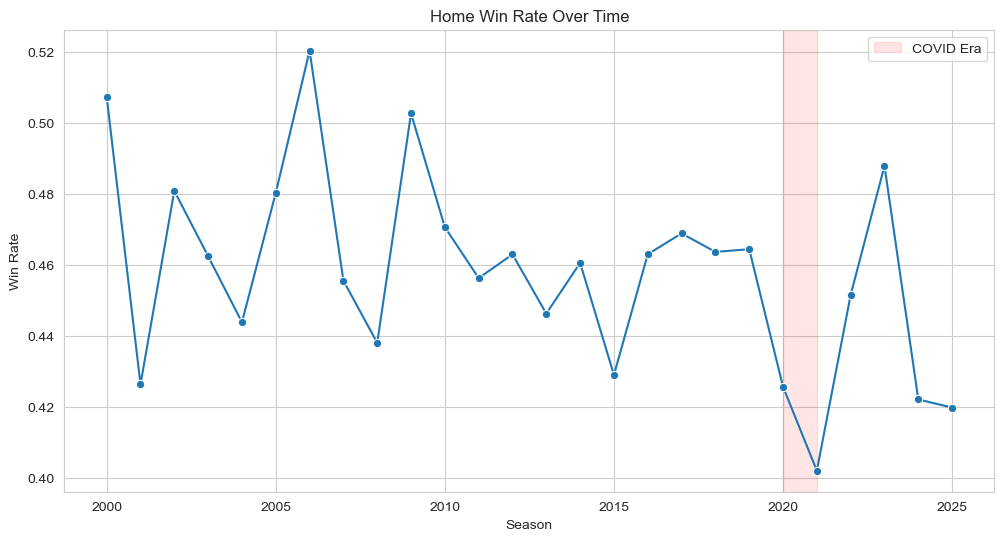

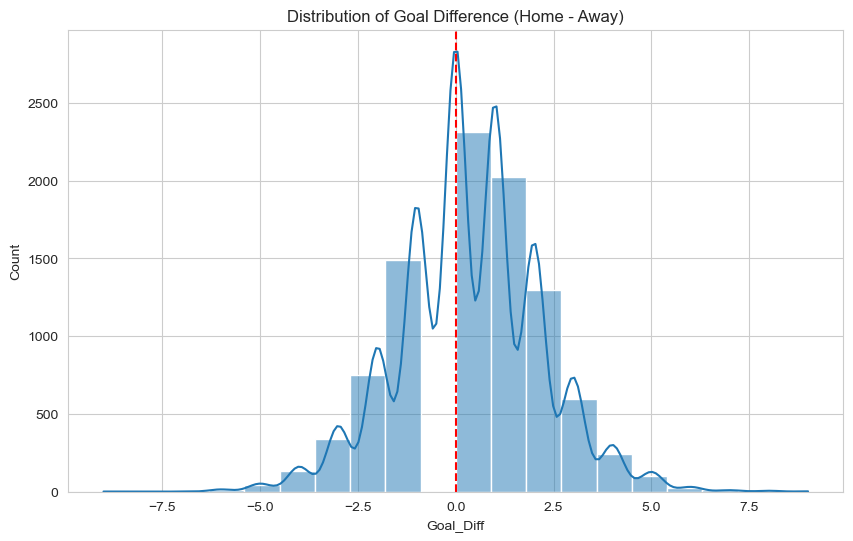

In [14]:
# 3. Exploratory Data Analysis
sns.set_style("whitegrid")

# Plot 1: Home Win Rate by Season
plt.figure(figsize=(12, 6))
season_stats = df.groupby('Season')['Home_Win'].mean()
sns.lineplot(x=season_stats.index, y=season_stats.values, marker='o')
plt.axvspan(2020, 2021, color='red', alpha=0.1, label='COVID Era')
plt.title('Home Win Rate Over Time')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

# Plot 2: Goal Difference Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Goal_Diff'], bins=20, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Goal Difference (Home - Away)')
plt.show()

In [15]:
# 4. Hypothesis Testing

# Test 1: Is Goal Difference significantly > 0?
t_stat, p_val = stats.ttest_1samp(df['Goal_Diff'], 0, alternative='greater')
print(f"Test 1 (Home Advantage) P-value: {p_val:.5f}")

# Test 2: Did Covid reduce Home Advantage?
normal_wins = df[df['Is_Covid'] == 0]['Home_Win']
covid_wins = df[df['Is_Covid'] == 1]['Home_Win']
t_stat_cov, p_val_cov = stats.ttest_ind(normal_wins, covid_wins, alternative='greater')
print(f"Test 2 (Covid Impact) P-value: {p_val_cov:.5f}")
print(f"Normal Win Rate: {normal_wins.mean():.3f}")
print(f"Covid Win Rate: {covid_wins.mean():.3f}")

Test 1 (Home Advantage) P-value: 0.00000
Test 2 (Covid Impact) P-value: 0.00457
Normal Win Rate: 0.461
Covid Win Rate: 0.401
